# Predicting Average Ratings of Board Games
#### Galen Ballew, 2017
#### Metis Data Science

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import sys, sklearn
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [ ]:
print("Python Version:", sys.version)
print()
print("Pandas Version:", pd.__version__)
print()
print("Numpy Version:", np.__version__)
print()
print("Sklearn:", sklearn.__version__)

In [17]:
import warnings
warnings.filterwarnings('ignore')

### Data Munging

In [ ]:
#%%writefile spider.py
import re

from bs4 import BeautifulSoup

from scrapy.spiders import CrawlSpider
from scrapy.item import Item, Field
from scrapy.crawler import CrawlerProcess


class Game(Item):
    id = Field()
    title = Field()
    geek_rate = Field()
    avg_rate = Field()
    num_votes = Field()

class GameSpider(CrawlSpider):
    name = 'boardgamegeek_spider'
    allowed_domains = ['boardgamegeek.com']
    start_urls = ['http://www.boardgamegeek.com/browse/boardgame']
    custom_settings = {'DOWNLOAD_DELAY': 1, 'BOT_NAME': 'Mr. Scraper Bot'}

    def parse(self, response):
        soup = BeautifulSoup(response.body, 'lxml')
        next_page = soup.select('a[title^="next"]')
        if next_page:
            next_page = next_page[0].get('href')
        if next_page:
            yield self.make_requests_from_url(response.urljoin(next_page))
        rows = soup.select('tr#row_')
        for row in rows:
            g = Game()
            a = row.find_all('a', href=re.compile('^/boardgame'))
            for r in a:
                if r.text:
                    g['id'] = r.get('href').split('/')[2]
                    g['title'] = r.text
            geek_rate, avg_rate, num_votes = row.select('td.collection_bggrating')
            g['geek_rate'] = geek_rate.text.strip()
            g['avg_rate'] = avg_rate.text.strip()
            g['num_votes'] = num_votes.text.strip()
            yield g

scrapy runspider spider.py -o items.csv  

This code is run inside of the scrapy shell. I couldn't figure out how to run it through the ipython kernel. 

In [ ]:
import csv

filename = 'items.csv'
reader = csv.reader(open(filename))
col = next(reader).index('id')
ids = [line[col] for line in reader]
ids = list(set(ids))
with open('ids.txt', 'w') as f:
    f.write('\n'.join(ids))

In [ ]:
import csv
import time
import requests
from bs4 import BeautifulSoup

def get_val(tag, term):
    try:
        val = tag.find(term)['value'].encode('utf_8', 'ignore')
    except:
        val = 'NaN'
    return val

base = 'http://www.boardgamegeek.com/xmlapi2/thing?id={}&stats=1'
with open('ids.txt') as f:
    ids = [line.strip() for line in f.readlines()]
split = 30
f = open('games.csv', 'w', encoding='utf8')
writer = csv.writer(f)
writer.writerow(('id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers', 'playingtime',
                 'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'average_rating',
                 'bayes_average_rating', 'total_owners', 'total_traders', 'total_wanters',
                 'total_wishers', 'total_comments', 'total_weights', 'average_weight'))
for i in range(0, len(ids), split):
    url = base.format(','.join(ids[i:i+split]))
    print('Requesting {}'.format(url))
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'xml')
    items = soup.find_all('item')
    for item in items:
        gid = item['id']
        gtype = item['type']
        gname = get_val(item, 'name')
        gyear = get_val(item, 'yearpublished')
        gmin = get_val(item, 'minplayers')
        gmax = get_val(item, 'maxplayers')
        gplay = get_val(item, 'playingtime')
        gminplay = get_val(item, 'minplaytime')
        gmaxplay = get_val(item, 'maxplaytime')
        gminage = get_val(item, 'minage')
        usersrated = get_val(item.statistics.ratings, 'usersrated')
        avg = get_val(item.statistics.ratings, 'average')
        bayesavg = get_val(item.statistics.ratings, 'bayesaverage')
        owners = get_val(item.statistics.ratings, 'owned')
        traders = get_val(item.statistics.ratings, 'trading')
        wanters = get_val(item.statistics.ratings, 'wanting')
        wishers = get_val(item.statistics.ratings, 'wishing')
        numcomments = get_val(item.statistics.ratings, 'numcomments')
        numweights = get_val(item.statistics.ratings, 'numweights')
        avgweight = get_val(item.statistics.ratings, 'averageweight')
        writer.writerow((gid, gtype, gname.decode(), gyear.decode(), gmin.decode(), gmax.decode(),
                         gplay.decode(), gminplay.decode(), gmaxplay.decode(), gminage.decode(),
                         usersrated.decode(), avg.decode(), bayesavg.decode(), owners.decode(),
                         traders.decode(), wanters.decode(), wishers.decode(), numcomments.decode(),
                         numweights.decode(), avgweight.decode()))
    time.sleep(2)
f.close()

In [95]:
#drop blank observations and games with less than 30 ratings
#chose 30 because it is a magic number 
games = pd.read_csv('games.csv')
games.dropna(axis=0, inplace=True)
games = games[games['users_rated'] > 30]
games.head(3)

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
2,12715,boardgame,De Bellis Renationis,1997.0,1.0,2.0,180.0,180.0,180.0,14.0,47,6.59894,5.55511,117,2,0,4,16,9,3.5556
5,2771,boardgame,Maginor,2001.0,2.0,4.0,45.0,45.0,45.0,12.0,328,5.49909,5.49931,739,78,3,14,144,38,1.8684
12,24762,boardgame,Medici vs Strozzi,2006.0,2.0,2.0,30.0,30.0,30.0,10.0,1538,6.52968,6.14922,1808,115,53,205,676,194,2.4485


### Exploratory Data Analysis

Average Rating Mean 6.539877705322105
Average Rating Standard Deviation 0.9206141433613703 



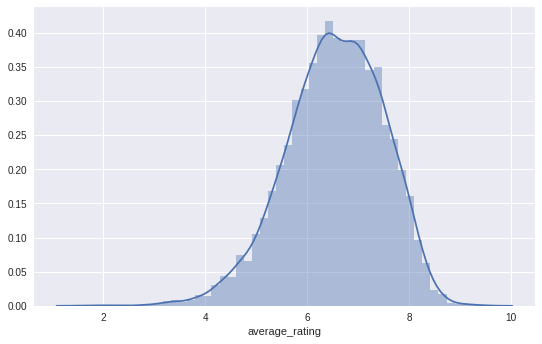

In [96]:
plt.figure()
sns.set(color_codes="True")
sns.distplot(games['average_rating'], kde=True);
#plt.savefig('target_mean_rating_hist.png')
print('Average Rating Mean %s' % games['average_rating'].mean())
print('Average Rating Standard Deviation %s \n' % y.std())

Target distribution is just slightly skewed left, but otherwise Gaussian. This is explained by the lack of 10/10 games, which are pragmatically non-existent on BoardGameGeek. Giving a 10 out 10 score would be considered unhelpful and without any critical thought in the review. Similiar phenomena can be seen somewhere like IMDb where the highest rated film of all time, *The Shawshank Redemption*, is rated 9.2 out of 10.  

Mean Squared Error will make for a good error metric since the distribution is continuous and close to Gaussian. 

In [97]:
#remove all the non-numeric Series
games.drop(['id', 'name', 'type'], axis=1, inplace=True)
#make sure all the columns are numbers
games = games.astype('float', copy=False)
games['yearpublished'].dtype

dtype('float64')

In [98]:
#remove games before 1990 and not out yet
games = games[(games['yearpublished'] > 1990) & (games['yearpublished'] < 2016)]

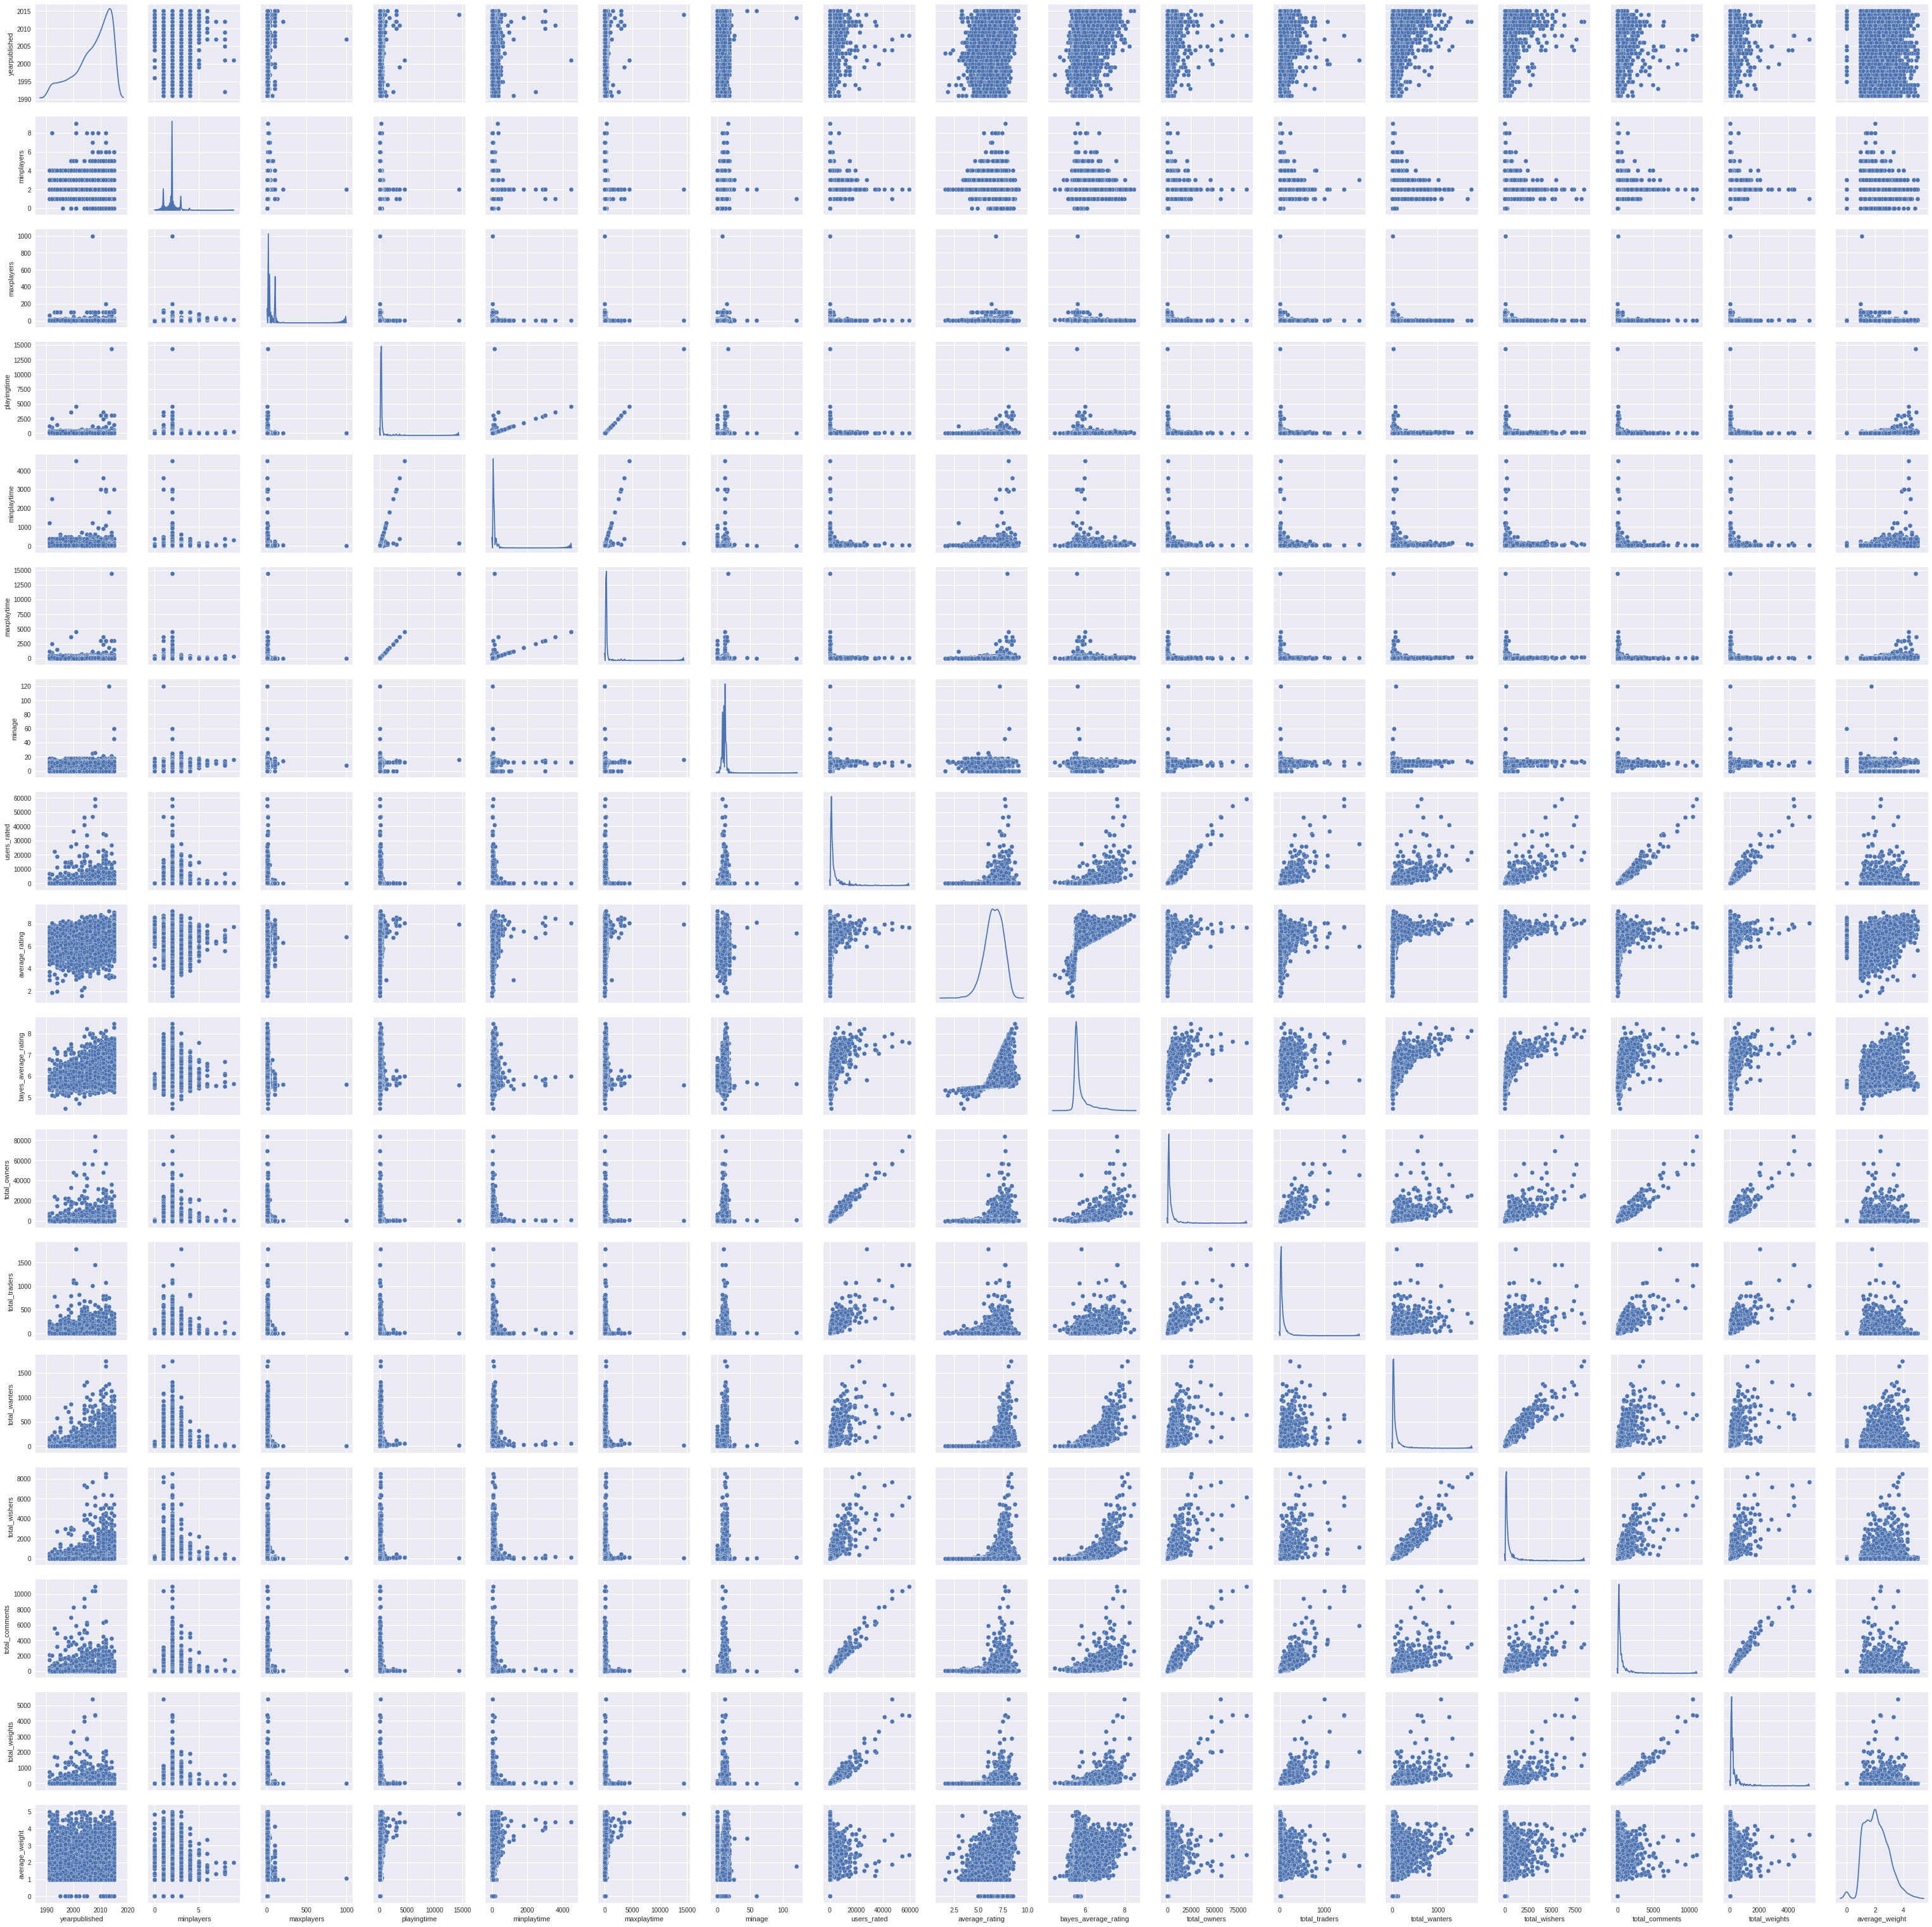

In [84]:
plt.figure()
sns.pairplot(games, kind='scatter', diag_kind='kde');
#plt.savefig('pairplot_numeric.png');

We can see 5 major linear correlations in the pair plot:

1. total_owners & users_rated
2. total_owners & total_weights
3. total_owners & total_comments
4. users_rated & total_weights
5. users_rated & total_comments

In [99]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
cluster.fit(games)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

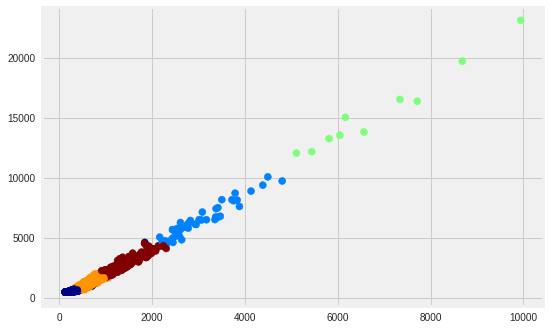

In [100]:
import matplotlib.cm as cm

plt.figure()
plt.style.use('fivethirtyeight')
plt.scatter(x=games.apply(np.mean, axis=1), y=games.apply(np.std, axis=1),
            c=cluster.labels_, cmap='jet');
#plt.savefig('cluster_mean_std.png')

This graph compares observation means and standard deviations. Although the metrics are not useful in themselves, it's interesting to look at them compared to other observations. What this graph shows is that many games are similiar. However, there is a small cluster (light green) that has very large values in their features. Essentially, most games have few ratings, owners, comments, etc.. but a few games generate an enormous amount of activity/volume.

In [101]:
correlations = games.corr()
correlations['average_rating']

yearpublished           0.343535
minplayers             -0.157085
maxplayers             -0.023168
playingtime             0.129372
minplaytime             0.167778
maxplaytime             0.129372
minage                  0.142092
users_rated             0.158617
average_rating          1.000000
bayes_average_rating    0.519805
total_owners            0.212425
total_traders           0.085101
total_wanters           0.325663
total_wishers           0.264644
total_comments          0.157510
total_weights           0.139691
average_weight          0.497152
Name: average_rating, dtype: float64

#### Explanation of average_weight
This is a community generated metric from BoardGameGeek. It is defined as "Community rating for how difficult a game is to understand. Lower rating (lighter weight) means easier." 

#### Explanation of total_wanters
This is the number of people who are looking for this game in the BoardGameGeek marketplace.

#### Explanation of total_wishers
This is the number of people who have added this game to their wishlist. 

In [102]:
#isolate the Target
y = games.pop('average_rating')
y = y.astype('float', copy=False)
y.dtype

dtype('float64')

In [104]:
#reduce complexity by removing uncorrelated features
#also remove features that have collinearity
#delete other avg rating
games.drop(['bayes_average_rating', 'total_traders', 'total_weights', 'total_comments', 'users_rated'],axis=1, inplace=True)
games.head()

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,total_owners,total_wanters,total_wishers,average_weight
2,1997.0,1.0,2.0,180.0,180.0,180.0,14.0,117.0,0.0,4.0,3.5556
5,2001.0,2.0,4.0,45.0,45.0,45.0,12.0,739.0,3.0,14.0,1.8684
12,2006.0,2.0,2.0,30.0,30.0,30.0,10.0,1808.0,53.0,205.0,2.4485
28,2011.0,3.0,5.0,50.0,50.0,50.0,14.0,251.0,49.0,120.0,1.4706
32,2001.0,2.0,2.0,20.0,20.0,20.0,10.0,571.0,11.0,19.0,1.5385


# Applying Linear Regression

In [120]:
# preprocess, instantiate model, fit the data to the model
games_standardized = preprocessing.scale(games)
lasso_cv = linear_model.LassoCV(cv=5, normalize=False, verbose=True, random_state=8)
lasso_cv.fit(games_standardized, y)
alpha = lasso_cv.alpha_
lasso_cv = linear_model.Lasso(alpha=alpha)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [121]:
lasso_cv.coef_

In [135]:
cv_score = cross_val_score(lasso_cv, games_standardized, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.mean(-cv_score) ** (1/2)
rmse

0.68754079102819499

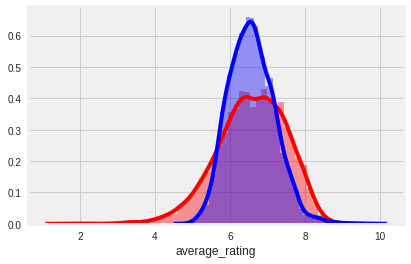

In [111]:
sns.distplot(y, color='red');
sns.distplot(predictions, color='blue');